# 전력수요예측 모델링

## 목차



### 1. 데이터 load

In [1]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(16909, 1301)
(8760, 201)


### 2. 결측치 파악

* train 데이터셋의 경우 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량을 나타내나 80%이상의 결측치를 갖는 값이 대부분임. test셋과 train셋의 세대가 다르기 때문에 우선 test셋의 데이터로 모델링을 진행해봄

In [6]:
# to_datetime

train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

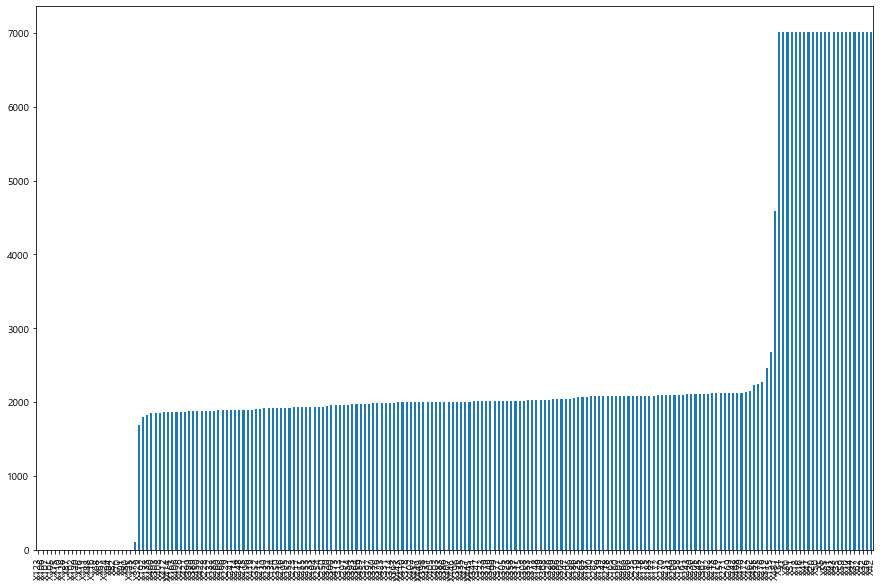

In [7]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

* 결측치가 없는 세대를 sample로 정하여 데이터 탐색 진행

In [7]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [9]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

* test_sample 데이터를 시간,일,월별로 resampleling

In [10]:
# 일
test_sample_day = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum()

# 월
test_sample_month = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='M').sum()

# 시간별
test_sample_hours = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

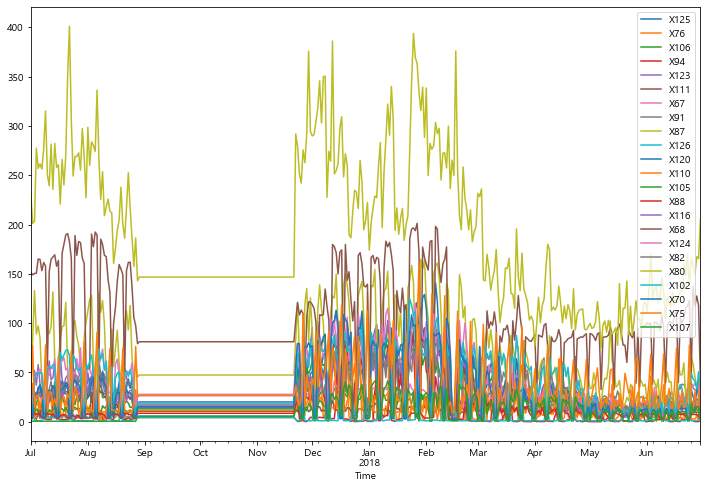

In [11]:
# 일별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

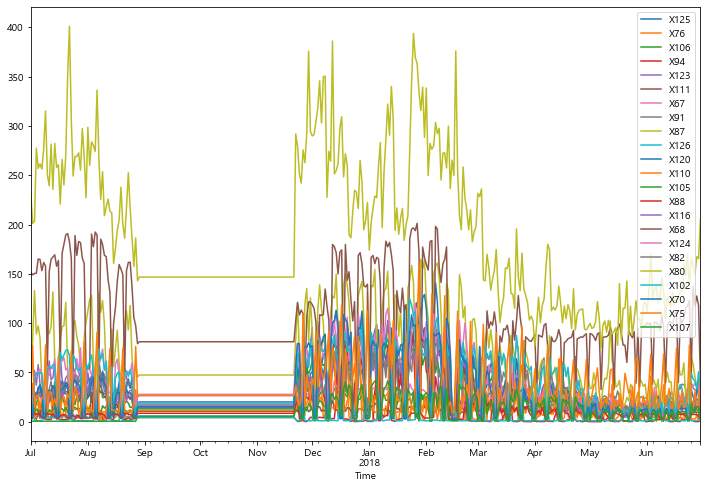

In [12]:
# 월별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].resample(rule='D').sum().plot(figsize=(12,8))

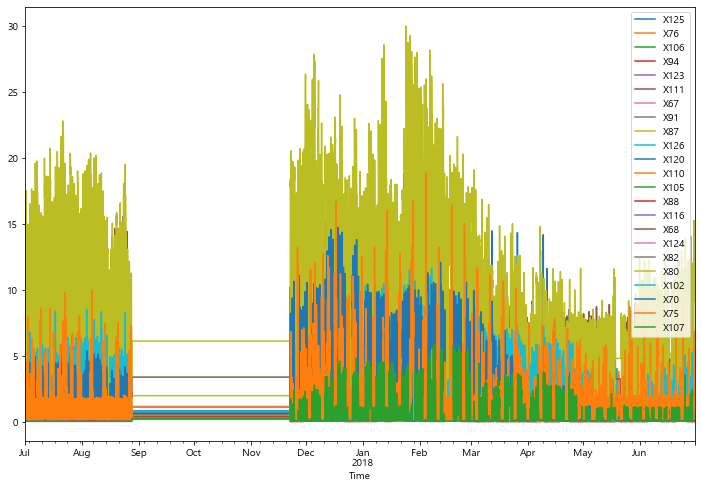

In [13]:
# 시간별 전력수요량 합계

test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']].plot(figsize=(12,8))

> 결측치가 없는 test_sample에서 2017년9월~11월 22일까지의 데이터가 같은값을 갖는 특징 확인.
    * 해당 특징이 오류인지, 특정 이유가 있는것인지 파악할 필요

> 시계열 예측을 위한 모델로 HOLT'S-WINTER, ARIMA모델을 적용해 볼것임.

> 모델 적용 전, 데이터 특성 파악 필요
    * 2017년9월~11월까지의 데이터 특징 파악
    * 주택데이터와 상가데이터의 구분
    * 계절,주말에 따른 트렌드 및 계절성 파악
    * 기온,날씨,공휴일 등 예측변수 탐색

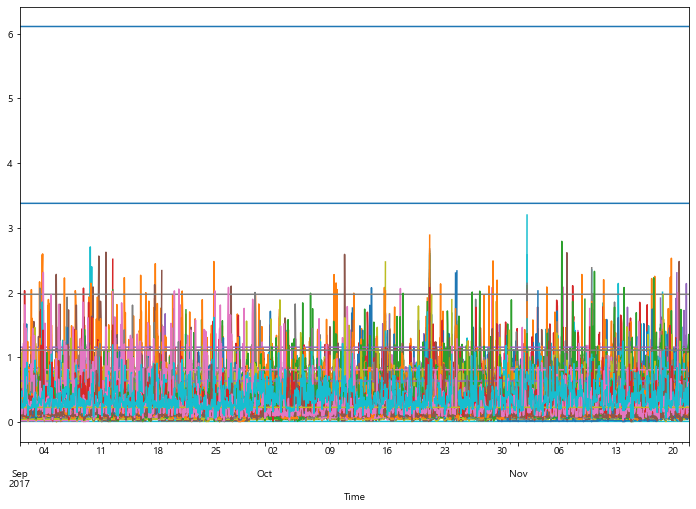

In [14]:
# test데이터 모든 데이터가 9월~11월말까지 같은 값을 갖는지 확인

test['2017-09':'2017-11-21'].plot(figsize=(12,8),legend=False)

> test셋의 모든 데이터가 17년 9월~11월말까지 같은 값을 가지는 것은 아니다.
    * 일부 데이터의 특징? vs 측정오류
    * 모델 적용시 설명력을 감소시킬 가능성 고려

* 전력수요량의 평균적인 크기로 상가와 주택을 구분해 보기

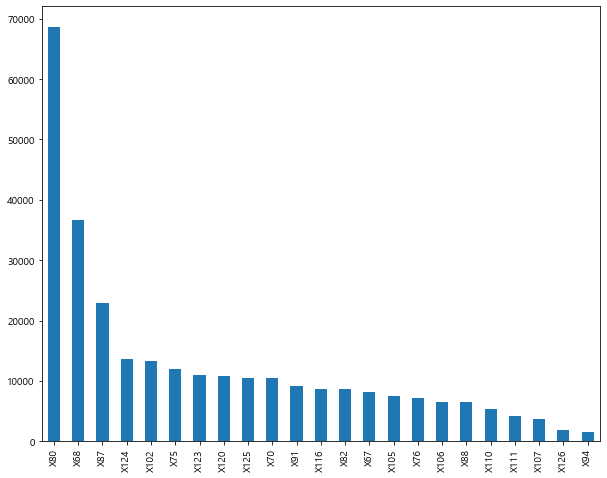

In [15]:
# 시각화 통한 판단
# 결측치 처리후 test 데이터 전체 시각화해보기
test_sample.iloc[:,].sum().sort_values(ascending=False).plot(kind='bar',figsize=(10,8))

### 3. ARIMA 

In [16]:
# X116 세대의 일별 예측을 sample로 Testing

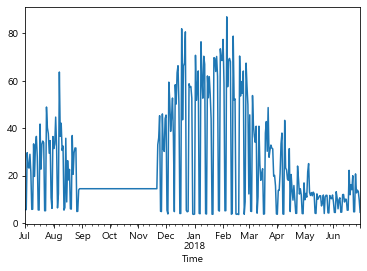

In [17]:
test_sample['X116'].resample(rule='D').sum().plot()

In [18]:
## 3.1 decompose

# decomposition 으로 확인하기

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(test_sample['X116'].resample(rule='D').sum())

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 432x288 with 0 Axes>

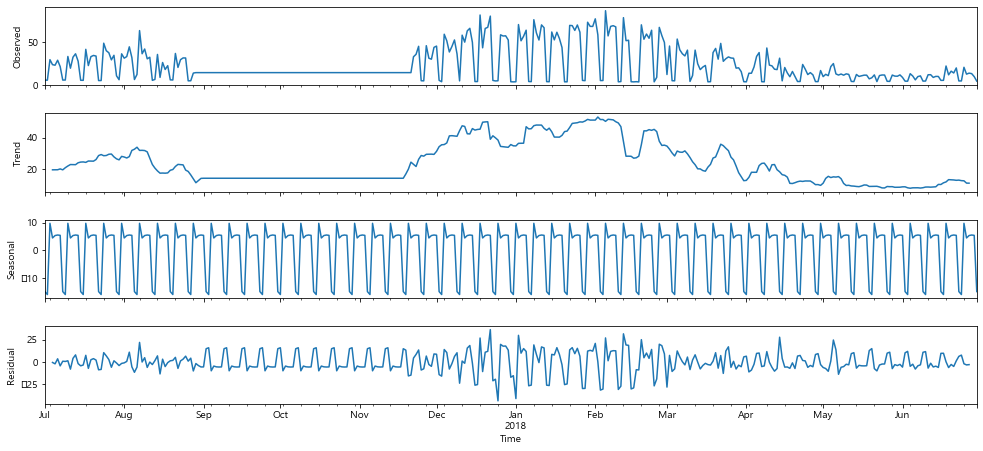

In [19]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

In [20]:
# 3.2 stationary Test

# stationary check
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [21]:
adf_check(test_sample['X116'].resample(rule='D').sum())

Non-Stationary 0.641699642360996


In [22]:
# 1st differencing
first_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).dropna())

Stationary 5.017885244993516e-10


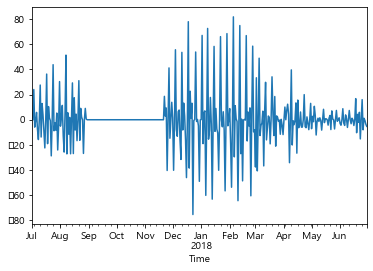

In [23]:
# 1st differencing plot
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(1)).plot()

In [24]:
# seasonal differencing
seasonal_diff = (test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna()
adf_check((test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).dropna())

Stationary 0.0003131105291293751


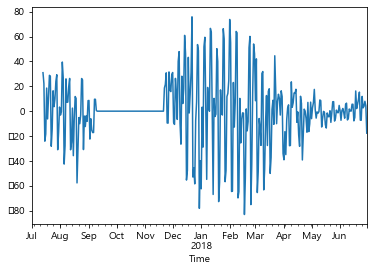

In [25]:
(test_sample['X116'].resample(rule='D').sum() - test_sample['X116'].resample(rule='D').sum().shift(12)).plot()

In [26]:
# 1st & seasonal differencing

res_diff = first_diff - seasonal_diff
adf_check(res_diff.dropna())

Stationary 0.022025364543090557


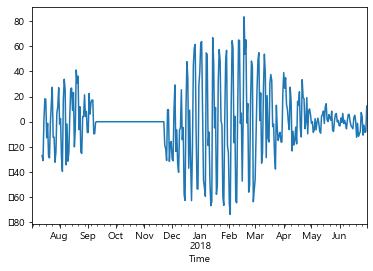

In [27]:
res_diff.plot()

In [28]:
# ARIMA

# parameter searching
import itertools
p = list(range(0,5))
d = [1]
q = [0,1]

pdq = list(itertools.product(p,d,q))

In [29]:
for param in pdq:
    model = ARIMA(test_sample['X116'], order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(se

ARIMA(0, 1, 0) => AIC : 25314.68595486614
ARIMA(0, 1, 1) => AIC : 25306.070592302593


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0) => AIC : 25308.295358380547
ARIMA(1, 1, 1) => AIC : 24532.596634943246
ARIMA(2, 1, 0) => AIC : 25210.989198067633


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1) => AIC : 24383.299870864998


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 0) => AIC : 25209.608333774475


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 1) => AIC : 24385.208331206137


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 0) => AIC : 25198.580024514355


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ARIMA(4, 1, 1) => AIC : 24329.44602718213


In [30]:
arima_sample = test_sample['X116'].resample(rule='D').sum()

# train ,test split
X = arima_sample.values
size = int(len(X)*0.66)
train_testing,test_testing = X[:size],X[size:]

In [31]:
history = [x for x in train_testing] # train은 그대로 두고 (복사본 생성)

In [32]:
predictions = []

for t in range(len(test_testing)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(4,1,1))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test_testing[t] 
    history.append(obs) # 하나씪 범위 늘림

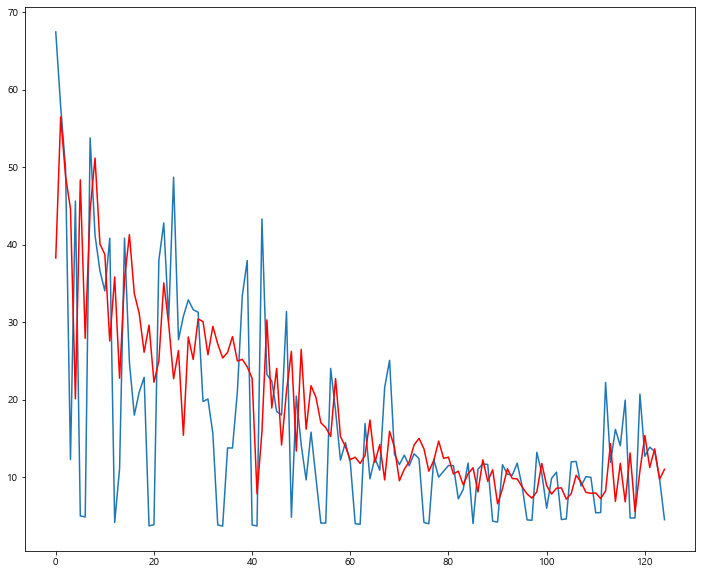

In [33]:
plt.figure(figsize=(12,10))
plt.plot(test_testing)
plt.plot(predictions,color='red')

In [34]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_testing,predictions)

In [35]:
rmse = np.sqrt(error)
rmse

11.161459221054315

In [36]:
arima_sample.describe()

count    365.00000
mean      23.78091
std       20.16818
min        3.55600
25%       10.49000
50%       14.44800
75%       33.87400
max       87.00300
Name: X116, dtype: float64

> 모델의 성능이 좋지 못하다. train 기간이 짧아서? 9~11월의 측정 이상 때문? 단순 시계열 모델의 한계?

> 머신러닝을 통한 예측을 해보자 

In [37]:
# 우선, 9~11월의 이상 관측치를 해결할것.

# 1. 9~11월의 정상 관측치와 기상데이터의 상관관계 분석 후, 회긔를 통한 예측

In [38]:
# 기상 데이터 load

weather_1 = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_1.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_1['지점']

weather_2= pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_2.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_2['지점']

weather = pd.concat([weather_1,weather_2])

FileNotFoundError: [Errno 2] File b'C:/Users/KIHyuk/Desktop/\xec\xa0\x84\xeb\xa0\xa5\xec\x88\x98\xec\x9a\x94\xec\x98\x88\xec\xb8\xa1/\xea\xb8\xb0\xec\x83\x81_1.csv' does not exist: b'C:/Users/KIHyuk/Desktop/\xec\xa0\x84\xeb\xa0\xa5\xec\x88\x98\xec\x9a\x94\xec\x98\x88\xec\xb8\xa1/\xea\xb8\xb0\xec\x83\x81_1.csv'

In [ ]:
weather.head()

In [ ]:
# 인천지역 2016-07-20 ~ 2018-06-30간의 기온,강수량,풍속,습도,일조

weather['기온(°C)'].plot()

In [ ]:
# 기온에 따른 전력수요량 파악하기

In [ ]:
test_sample['기온'] = weather['기온(°C)']['2017-07':'2018-06']

In [ ]:
# 기온이 0도 이하로 떨어질 경우 전력 수요량

test_sample['기온'].resample('M').mean() # 월별 평균기온

In [ ]:
# 6,7,8,9 / 11,3 / 12,1,2  / 4,5 / 10  

In [ ]:
# 6,7,8월
# 여러 세대로 TEST 해볼것

plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(test_sample['기온']['2017-06':'2017-08'].resample(rule='D').mean(), test_sample['X125']['2017-06':'2017-08'].resample(rule='D').sum(),s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

> 기온이 높아질수록 전기수요량 또한 높아짐

In [ ]:
# 6,7,8월
# 여러 세대로 TEST 해볼것

plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(test_sample['기온']['2017-12':'2018-02'].resample(rule='D').mean(), test_sample['X125']['2017-12':'2018-02'].resample(rule='D').sum(),s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

> 온도가 0~영하권일 경우 평균적인 전력사용량이 높음

In [ ]:
test_sample.columns

In [ ]:
# test 셋중 결측치 있는 세대
test_sample_nan = test.loc[:,test.isnull().sum() > 0]

In [ ]:
test_sample_nan['2017-09':'2017-11-21'].isnull().sum().sort_values(ascending=True)

In [ ]:
test_sample_nan = test_sample_nan['2017-09':'2017-11-21'].loc[:,test_sample_nan['2017-09':'2017-11-21'].isnull().sum() < 656]

In [ ]:
test_sample_nan = test_sample_nan.reset_index()

In [ ]:
test_sample_nan

In [ ]:
for k in range(1, len(test_sample_nan.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test_sample_nan.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test_sample_nan.loc[ test_sample_nan.iloc[:,k].isnull()==False ][ test_sample_nan.columns[k] ].index

    df=DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )

    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test_sample_nan.iloc[i,k]>=test_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test_sample_nan.iloc[ i : i+j+1 , k] = test_sample_nan.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:  
            pass #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

In [ ]:
test_sample_nan.set_index('Time', inplace=True) # Date를 인덱스로

# 1차 결측치 제거 후 결측치는 시간에따른보간법으로 채움
test_sample_nan = test_sample_nan.interpolate(method='time')

In [ ]:
test_sample_nan.isnull().sum()

In [ ]:
test_sample_nan.resample('D').sum().plot(figsize=(10,8),legend=False)

In [ ]:
weather['기온(°C)']['2017-09':'2017-11-22'].resample('D').mean().plot()

In [ ]:
test_sample_nan.columns

In [ ]:
plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(weather['기온(°C)']['2017-09':'2017-11-21'], test_sample_nan['X435'],s=0.5,
            color="red", label='electricity consumption(measured)')
plt.show()

In [ ]:
# # 학습과 성능의 평가

# from sklearn.model_selection import KFold
# import sklearn.svm

# data_count = len(test_sample_nan['X435'])

# # 교차검정의 준비
# kf = KFold(n_splits=5)

# # 교차검정 실시(모든 패턴을 실시)
# for train, test in kf.split(weather['기온(°C)']['2017-09':'2017-11-21']):
#     x_train = weather['기온(°C)']['2017-09':'2017-11-21'][train]
#     x_test = weather['기온(°C)']['2017-09':'2017-11-21'][test]
#     y_train = test_sample_nan['X435'][train]
#     y_test = test_sample_nan['X435'][test]

#     # -- SVR --
#     model = sklearn.svm.SVR()
#     y_train = y_train.values.flatten()
#     y_test = y_test.values.flatten()
    
#     model.fit(x_train, y_train)
#     print ("SVR: Training Score = %f, Testing(Validate) Score = %f" %
#            (model.score(x_train, y_train), model.score(x_test, y_test)))

In [ ]:
# Annual	1
# Quarterly	4
# Monthly	12
# Weekly	52

In [ ]:
test_sample.columns

In [ ]:
test_sample.loc[:,:'X107'].plot(figsize=(10,8),legend=False)

In [ ]:
test_sample.columns

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
test_sample['X76'][:'2017-08'].resample('D').sum().plot()

In [ ]:
winter_model = ExponentialSmoothing(np.asarray(test_sample['X76'][:'2017-08'].resample('D').sum()),
                                   seasonal_periods=12, # 인자로 계절성파악위해 주기 주어야함(12개월 주기)
                                    trend='add', # addtive
                                    seasonal='add' # addtive
                                   ) 

In [ ]:
winter_result = winter_model.fit()

In [ ]:
y_hat = test_sample['2017-08-20':'2017-08-22'].resample('D').sum().copy() # 원본 test데이터 오염방지위해)

In [ ]:
y_hat['WINTER'] = winter_result.forecast(len(test_sample['X125']['2017-08-20':'2017-08-22'].resample('D').sum()))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_sample['X125'][:'2017-08-31'].resample('D').sum(), label='Train')
plt.plot(y_hat[['WINTER']], label='HOLT-WINTER')
plt.legend()

In [ ]:
from statsmodels.tsa.api import Holt

In [ ]:
holt_model = Holt(np.asarray(np.asarray(test_sample['X125'][:'2017-08'])))

In [ ]:
holt_result = holt_model.fit()

In [ ]:
y_hat['HOLT'] = holt_result.forecast(len(test_sample['X125']['2017-08-15':'2017-08']))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_sample['X125'][:'2017-08-31'], label='Train')
# plt.plot(train['Thousands of Passengers'], label='Test')
plt.plot(y_hat[['HOLT']], label='Holts Exp Smoothing')
plt.legend()

In [ ]:
test_sample['X125'].plot(figsize=(10,10))